This is the notebook for the AIcrowd challenge https://www.aicrowd.com/challenges/chunin-exams-food-track-cv-2021 where we train a convolutional neural network to classify a given image as one of the 62 food labels/classes.

Link to combined (training and testing) dataset: https://drive.google.com/file/d/1M6KeA1UA3_VaH0kGtjOJlUQiTeNoZYSx/view?usp=sharing

First download the data zip file to the same directory as the notebook to be able to run the network.
A trained model can be downloaded from https://drive.google.com/file/d/1_PxYjdNnpWcdCAo2DnWFaLOSEDWvgvfu/view?usp=sharing

We begin by simply importing all the required libraries.

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import pandas as pd
import time
import copy

import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

Unzip the concerned zip file containing all the training and testing data to be used.

In [6]:
from zipfile import ZipFile
file_name = "./data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


Now we import all the classes/labels as a dictionary where the classes form the keys and the values are indices to be used for those respective classes in the optimizer during training.

In [5]:
classes = {}
classFile = open("./classes.txt")

for line in classFile:
    value, key = line.split()
    classes[key] = (int)(value)

Below we define a class for our custom dataset. This class will be used to generate the dataset in the required format along with the required functionality such as returning a sample from the dataset after applying the appropriate transformations, etc.

In [7]:
class CustomDataSet(Dataset):
    """Custom dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = mpimg.imread(img_name)
        label = self.data.iloc[idx, 0]
        if(np.shape(self.data)[1] == 2):
            label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label}
        return sample

Now we define the transformations to be applied on the training images to help build a better model. We also instantiate our dataset as an instance of the class we had created for our custom data set with the training data given to us.

In [8]:
transformData = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
dataset = CustomDataSet(csv_file='./data/train.csv', root_dir='./data/train_images', transform=transformData)

validation_split = 0.1
batch_size = 16
random_seed = 42

Next we divide our training data into 2 sets: a training set and a validation set. We then give the divided datasets along with various parameters such as batch size to a dataloader which will be used as the interface to access the data in batches of some size.

In [11]:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(random_seed)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainLoader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validLoader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)

Here we define the transformations for the testing set and inititate the dataset and the dataloader for the same. This is the dataset for which we are required to submit our results on the challenge page.

In [12]:
transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
testSet = CustomDataSet(csv_file='./data/test.csv', root_dir='./data/test_images', transform=transformTest)
testLoader = DataLoader(testSet, batch_size=batch_size, shuffle=False, num_workers=2)

nets = {}

Next we define our default neural network as a class. Our network primarily consists of a few convolutional layers followed by pooling layers and ends with some linear fully connected layers. The network primarily uses max pooling and ReLU as an activation function.

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 18, 5)
        self.fc1 = nn.Linear(18 * 28 * 28, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 62)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
nets['Default'] = Net()

Network with batch normalization layer between each pair of layers.

In [14]:
class BNormNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.norm2 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.norm3 = nn.BatchNorm2d(10)
        self.conv3 = nn.Conv2d(10, 18, 5)
        self.norm4 = nn.BatchNorm1d(18 * 28 * 28)
        self.fc1 = nn.Linear(18 * 28 * 28, 8192)
        self.norm5 = nn.BatchNorm1d(8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.norm6 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 256)
        self.norm7 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 62)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(self.norm(x))))
        x = self.pool(F.relu(self.conv2(self.norm2(x))))
        x = self.pool(F.relu(self.conv3(self.norm3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(self.norm4(x)))
        x = F.relu(self.fc2(self.norm5(x)))
        x = F.relu(self.fc3(self.norm6(x)))
        x = self.fc4(self.norm7(x))
        return x
    
nets['BatchNorm'] = BNormNet()

Network with dropout before each linear layer.

In [15]:
class DropNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 18, 5)
        self.fc1 = nn.Linear(18 * 28 * 28, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 62)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
nets['Dropout'] = DropNet()

Network with different activation functions for different layers.

In [16]:
class ActNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 18, 5)
        self.fc1 = nn.Linear(18 * 28 * 28, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 62)
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.softmax(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
nets['Activation'] = ActNet()

Network with different pooling strategies.

In [17]:
class PoolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.conv3 = nn.Conv2d(10, 18, 5)
        self.fc1 = nn.Linear(18 * 28 * 28, 8192)
        self.fc2 = nn.Linear(8192, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 62)
        self.pool = nn.AvgPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
nets['Pooling'] = PoolNet()

Here we define a function for training our network taking the dataloaders, loss function, optimization function and network/model as input. This function also runs the validation step after the training in each epoch to help visualize the progress in our network's performance with each epoch.

In [33]:
def train_model(model, dataloaders, criterion, optimizer, breakPt=-1, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, data in enumerate(dataloaders[phase]):
                if(breakPt != -1 and idx >= breakPt):
                    break
                
                inputs = data['image'].to(device)
                temp = data['label']
                targets = []

                for label in temp:
                    targets.append(classes[label])
                
                targets = torch.tensor(targets)
                labels = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if idx % 200 == 199:    # print every 500 mini-batches
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, idx + 1, running_loss / 1000))

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Here we define the various parameters to be used in the training function such as the loss function, device, etc.

In [23]:
dataloaders_dict = { 'train': trainLoader, 'val': validLoader }
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

Here we train all the different models and compare their performances. We also try training each of the models with a different optimizer (SGD and AdamW here) and compare their performances as well.

We find that among the different variations we have tried, the networks perform significantly better with the AdamW optimizer irrespective of the network design itself. Among the networks itself, we find that mainly only the network with batch normalization seemed to perform better than the default network. We can assume that the pooling strategies and activation functions used in the default network are good enough (maybe even optimal) and do not need change. We also may avoid dropout but must definitely adopt batch normalization.



Default
Epoch 0/9
----------
[1,   200] loss: 10.678
train Loss: 1.1454 Acc: 0.0600
val Loss: 0.3403 Acc: 0.0162

Epoch 1/9
----------
[2,   200] loss: 10.633
train Loss: 1.1405 Acc: 0.0596
val Loss: 0.3323 Acc: 0.0189

Epoch 2/9
----------
[3,   200] loss: 10.454
train Loss: 1.1213 Acc: 0.0646
val Loss: 0.3315 Acc: 0.0176

Epoch 3/9
----------
[4,   200] loss: 10.276
train Loss: 1.1022 Acc: 0.0686
val Loss: 0.3303 Acc: 0.0179

Epoch 4/9
----------
[5,   200] loss: 10.152
train Loss: 1.0889 Acc: 0.0701
val Loss: 0.3312 Acc: 0.0189

Epoch 5/9
----------
[6,   200] loss: 10.078
train Loss: 1.0810 Acc: 0.0745
val Loss: 0.3269 Acc: 0.0176

Epoch 6/9
----------
[7,   200] loss: 9.908
train Loss: 1.0628 Acc: 0.0748
val Loss: 0.3172 Acc: 0.0218

Epoch 7/9
----------
[8,   200] loss: 9.725
train Loss: 1.0432 Acc: 0.0769
val Loss: 0.3182 Acc: 0.0195

Epoch 8/9
----------
[9,   200] loss: 9.599
train Loss: 1.0296 Acc: 0.0782
val Loss: 0.3320 Acc: 0.0192

Epoch 9/9
----------
[10,   200] loss: 9.

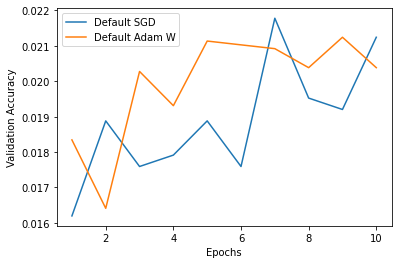

BatchNorm
Epoch 0/9
----------
[1,   200] loss: 11.964
train Loss: 1.2832 Acc: 0.0485
val Loss: 0.3596 Acc: 0.0151

Epoch 1/9
----------
[2,   200] loss: 10.536
train Loss: 1.1302 Acc: 0.0719
val Loss: 0.3267 Acc: 0.0228

Epoch 2/9
----------
[3,   200] loss: 9.487
train Loss: 1.0176 Acc: 0.0912
val Loss: 0.3154 Acc: 0.0218

Epoch 3/9
----------
[4,   200] loss: 8.805
train Loss: 0.9444 Acc: 0.1083
val Loss: 0.3094 Acc: 0.0219

Epoch 4/9
----------
[5,   200] loss: 7.876
train Loss: 0.8448 Acc: 0.1334
val Loss: 0.3161 Acc: 0.0204

Epoch 5/9
----------
[6,   200] loss: 6.942
train Loss: 0.7446 Acc: 0.1598
val Loss: 0.3119 Acc: 0.0222

Epoch 6/9
----------
[7,   200] loss: 5.705
train Loss: 0.6119 Acc: 0.1974
val Loss: 0.3185 Acc: 0.0210

Epoch 7/9
----------
[8,   200] loss: 4.646
train Loss: 0.4984 Acc: 0.2269
val Loss: 0.3229 Acc: 0.0221

Epoch 8/9
----------
[9,   200] loss: 3.732
train Loss: 0.4003 Acc: 0.2551
val Loss: 0.3272 Acc: 0.0194

Epoch 9/9
----------
[10,   200] loss: 2.89

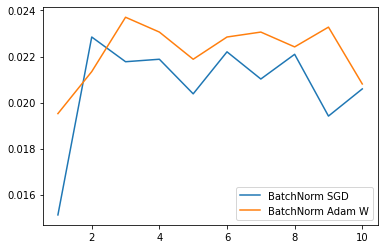

Dropout
Epoch 0/9
----------
[1,   200] loss: 13.158
train Loss: 1.4114 Acc: 0.0163
val Loss: 0.4092 Acc: 0.0057

Epoch 1/9
----------
[2,   200] loss: 12.911
train Loss: 1.3848 Acc: 0.0284
val Loss: 0.3847 Acc: 0.0089

Epoch 2/9
----------
[3,   200] loss: 12.250
train Loss: 1.3140 Acc: 0.0314
val Loss: 0.3806 Acc: 0.0089

Epoch 3/9
----------
[4,   200] loss: 12.154
train Loss: 1.3036 Acc: 0.0308
val Loss: 0.3794 Acc: 0.0089

Epoch 4/9
----------
[5,   200] loss: 12.134
train Loss: 1.3015 Acc: 0.0314
val Loss: 0.3778 Acc: 0.0089

Epoch 5/9
----------
[6,   200] loss: 12.085
train Loss: 1.2963 Acc: 0.0317
val Loss: 0.3784 Acc: 0.0089

Epoch 6/9
----------
[7,   200] loss: 12.041
train Loss: 1.2916 Acc: 0.0336
val Loss: 0.3760 Acc: 0.0088

Epoch 7/9
----------
[8,   200] loss: 12.010
train Loss: 1.2882 Acc: 0.0315
val Loss: 0.3712 Acc: 0.0097

Epoch 8/9
----------
[9,   200] loss: 11.811
train Loss: 1.2668 Acc: 0.0430
val Loss: 0.3668 Acc: 0.0125

Epoch 9/9
----------
[10,   200] loss:

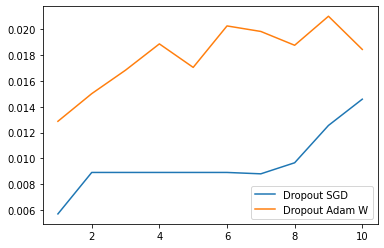

Activation
Epoch 0/9
----------
[1,   200] loss: 13.164
train Loss: 1.4120 Acc: 0.0281
val Loss: 0.4094 Acc: 0.0089

Epoch 1/9
----------
[2,   200] loss: 13.058
train Loss: 1.4006 Acc: 0.0323
val Loss: 0.4061 Acc: 0.0089

Epoch 2/9
----------
[3,   200] loss: 12.943
train Loss: 1.3883 Acc: 0.0326
val Loss: 0.4029 Acc: 0.0089

Epoch 3/9
----------
[4,   200] loss: 12.829
train Loss: 1.3760 Acc: 0.0320
val Loss: 0.3996 Acc: 0.0089

Epoch 4/9
----------
[5,   200] loss: 12.726
train Loss: 1.3650 Acc: 0.0334
val Loss: 0.3964 Acc: 0.0089

Epoch 5/9
----------
[6,   200] loss: 12.662
train Loss: 1.3581 Acc: 0.0295
val Loss: 0.3935 Acc: 0.0089

Epoch 6/9
----------
[7,   200] loss: 12.544
train Loss: 1.3455 Acc: 0.0323
val Loss: 0.3906 Acc: 0.0089

Epoch 7/9
----------
[8,   200] loss: 12.430
train Loss: 1.3333 Acc: 0.0319
val Loss: 0.3879 Acc: 0.0089

Epoch 8/9
----------
[9,   200] loss: 12.361
train Loss: 1.3258 Acc: 0.0328
val Loss: 0.3858 Acc: 0.0089

Epoch 9/9
----------
[10,   200] lo

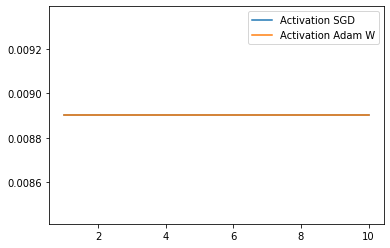

Pooling
Epoch 0/9
----------
[1,   200] loss: 13.166
train Loss: 1.4122 Acc: 0.0136
val Loss: 0.4092 Acc: 0.0089

Epoch 1/9
----------
[2,   200] loss: 13.000
train Loss: 1.3945 Acc: 0.0320
val Loss: 0.4005 Acc: 0.0089

Epoch 2/9
----------
[3,   200] loss: 12.382
train Loss: 1.3281 Acc: 0.0339
val Loss: 0.3825 Acc: 0.0089

Epoch 3/9
----------
[4,   200] loss: 12.254
train Loss: 1.3144 Acc: 0.0296
val Loss: 0.3816 Acc: 0.0089

Epoch 4/9
----------
[5,   200] loss: 12.141
train Loss: 1.3023 Acc: 0.0302
val Loss: 0.3798 Acc: 0.0089

Epoch 5/9
----------
[6,   200] loss: 12.078
train Loss: 1.2955 Acc: 0.0339
val Loss: 0.3746 Acc: 0.0105

Epoch 6/9
----------
[7,   200] loss: 11.778
train Loss: 1.2634 Acc: 0.0415
val Loss: 0.3646 Acc: 0.0121

Epoch 7/9
----------
[8,   200] loss: 11.592
train Loss: 1.2434 Acc: 0.0447
val Loss: 0.3594 Acc: 0.0136

Epoch 8/9
----------
[9,   200] loss: 11.337
train Loss: 1.2160 Acc: 0.0506
val Loss: 0.3549 Acc: 0.0133

Epoch 9/9
----------
[10,   200] loss:

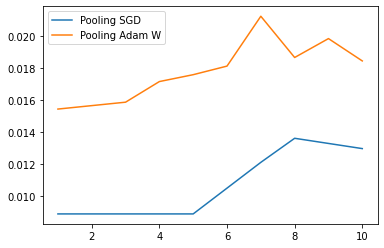

In [32]:
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

for key in nets:
    net = nets[key]
    net = net.to(device)

    print(key)
    sgd_optimizer_conv = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    sgd_exp_lr_scheduler = optim.lr_scheduler.StepLR(sgd_optimizer_conv, step_size=5, gamma=0.1)

    adamw_optimizer_conv = optim.AdamW(net.parameters(), lr=0.001)
    # Decay LR by a factor of 0.1 every 7 epochs
    adamw_exp_lr_scheduler = optim.lr_scheduler.StepLR(adamw_optimizer_conv, step_size=5, gamma=0.1)

    sgdbest, sgdhist = train_model(net, dataloaders_dict, criterion, sgd_optimizer_conv, 200, 10)
    print("Done with SGD " + key)
    
    adamwbest, adamwhist = train_model(net, dataloaders_dict, criterion, adamw_optimizer_conv, 200, 10)
    print("Done with Adam W " + key)
        
    plt.plot(range(1, 11), sgdhist)
    plt.plot(range(1, 11), adamwhist)
    plt.legend([key + " SGD", key + " Adam W"])
    
    plt.show()

Here we train the actual model making use of the analysis from above to use the optimal network and optimization function. We also save the model.

In [34]:
adamw_optimizer_conv = optim.AdamW(net.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
adamw_exp_lr_scheduler = optim.lr_scheduler.StepLR(adamw_optimizer_conv, step_size=5, gamma=0.1)  
best, hist = train_model(nets['BatchNorm'], dataloaders_dict, criterion, adamw_optimizer_conv)

PATH = './model.pth'
torch.save(best, PATH)        

Epoch 0/24
----------
[1,   200] loss: 9.561
[1,   400] loss: 19.232
train Loss: 2.6976 Acc: 0.2166
val Loss: 0.3064 Acc: 0.0237

Epoch 1/24
----------
[2,   200] loss: 9.455
[2,   400] loss: 18.987
train Loss: 2.6689 Acc: 0.2186
val Loss: 0.3036 Acc: 0.0248

Epoch 2/24
----------
[3,   200] loss: 9.581
[3,   400] loss: 19.204
train Loss: 2.6886 Acc: 0.2207
val Loss: 0.3070 Acc: 0.0241

Epoch 3/24
----------
[4,   200] loss: 9.517
[4,   400] loss: 19.055
train Loss: 2.6903 Acc: 0.2184
val Loss: 0.3033 Acc: 0.0245

Epoch 4/24
----------
[5,   200] loss: 9.501
[5,   400] loss: 18.984
train Loss: 2.6726 Acc: 0.2160
val Loss: 0.3036 Acc: 0.0248

Epoch 5/24
----------
[6,   200] loss: 9.595
[6,   400] loss: 19.172
train Loss: 2.6878 Acc: 0.2184
val Loss: 0.3034 Acc: 0.0241

Epoch 6/24
----------
[7,   200] loss: 9.566
[7,   400] loss: 19.133
train Loss: 2.6813 Acc: 0.2218
val Loss: 0.3045 Acc: 0.0245

Epoch 7/24
----------
[8,   200] loss: 9.594
[8,   400] loss: 19.102
train Loss: 2.6918 Ac

Finally we generate our predictions for the testing set and write the outputs to the required file.

In [45]:
ans = []
net = best.to(device)

with torch.no_grad():
    for data in enumerate(testLoader, 0):
        images = data[1]['image']
        labels = data[1]['label']
        
        images = images.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        vals = list(classes.values())
        keys = list(classes.keys())
        ctr = 0
        for elem in predicted:
            ans.append([labels[ctr], keys[vals.index(elem)]])
            ctr += 1
    
output = pd.DataFrame(ans)
output.to_csv('./test.csv', index=False, sep=',')